<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Analisis_salto_vertical_Fuerzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis del salto vertical a partir de las fuerzas de reacción del suelo (en construcción)

En este notebook vamos a tratar de describir y analizar los principales test de salto que se emplean para valorar la capacidad de generar fuerza explosiva en el tren inferior. 

In [ ]:
import numpy as np #tipo de datos Numpy
import pandas as pd #tipo de datos Pandas
import matplotlib.pyplot as plt #librería básica para representar gráficas

Empezaremos cargando en memoria un archivo con las fuerzas registradas en un salto vertical con contramovimiento o CMJ (del inglés *Counter Movement Jump*).

En este caso, se trata de un registro realizado con una plataforma de fuerzas de la marca Kistler con su propio software Bioware.

En este caso, por simplificar accedemos directamente al archivo concreto que se encuentra en el repositorio de Github BiomecanicaPython. Si quisieras abrir un archivo alojado localmente en tu ordenador, simplemente tendrías que meter en la variable nomArchSalto la ruta donde se encuentre el archivo. Si estás ejecutando este notebook desde Google Colaboratory, por motivos de seguridad, tendrás que acceder primero al archivo por alguno de los métodos que permite.

Es conveniente antes de ponerse a trabajar con el archivo, ver qué contiene. Como es un archivo de texto se puede abrir con cualquier lector de archivos de texto, como el Bloc de Notas.

In [ ]:
from IPython.display import Image
Image(url='https://github.com/joselvira/BiomecanicaPython/raw/master/Imagenes/ArchivoSaltosCrudo.png', height=400)

Como se ve en la figura anterior, el archivo empieza con una serie de datos sobre cómo se realizó el registro, que ahora no nos interesan.

El encabezado con la descripción de los datos empieza en la fila número 17 (la primera se cuenta como cero), y los datos en sí en la fila 19. Esto es importante conocerlo para poder realizar correctamente el proceso de lectura del archivo. En total hay cuatro columnas de datos, la primera corresponde al tiempo en segundos, y las otras a las fuerzas en los tres ejes del espacio.

En la siguiente celda se utiliza la librería Pandas para cargar el archivo. Fíjate que se indica la fila del encabezado (header=17) y que se salte la fila 18 (skiprows=[18]), que solamente incluye las unidades. Finalmente, el separador que utilizan estos archivos es el tabulador, que se representa con el símbolo \t.

In [ ]:
nomArchSalto = 'https://raw.githubusercontent.com/joselvira/BiomecanicaPython/master/Datos/PlatFuerzas/Saltos/BiowareSaltos-5.txt' #archivo con el registro de las fuerzas en un salto.
separador= '\t'

dfDatos = pd.read_csv(nomArchSalto, header=17, skiprows=[18], sep=separador) #con values lo pasa directamente a array de numpy
dfDatos

,abs time (s),Fx,Fy,Fz
0,0.000,-1.968899,-1.053477,602.418762
1,0.001,-2.288167,-1.372931,600.676270
2,0.002,-2.448239,-1.532773,599.248703
3,0.003,-2.288167,-1.492755,600.992996
4,0.004,-1.968899,-1.213090,602.578865
...,...,...,...,...
7995,7.995,-1.519445,-0.863344,601.274384
7996,7.996,-1.559830,-0.783537,601.433578
7997,7.997,-1.958986,-1.222357,598.737740
7998,7.998,-1.999078,-1.182570,599.369911


Echamos un primer vistazo a los datos, representándolos gráficamente.

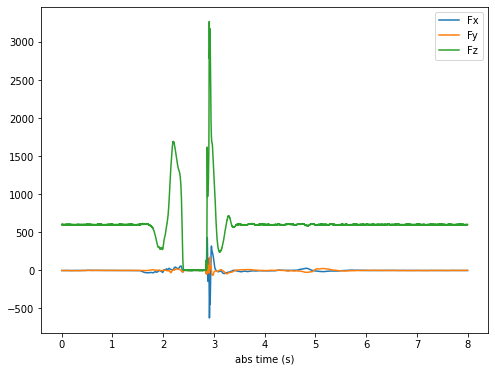

In [ ]:
dfDatos.plot(x='abs time (s)', figsize=(8,6))

Por simplificar, pasamos las variables que interesan a variables numpy. Nos interesa especialmente la columna del tiempo y la fuerza vertical (Fz).

In [ ]:
t = dfDatos['abs time (s)'].to_numpy() #tiempo
Fz = dfDatos['Fz'].to_numpy() #fuerza vertical
frec = 1/(t[1]-t[0]) #frecuencia de registro


Empezaremos por calcular el peso, ya que es necesario para calcular otras variables que utilizaremos. La fuerza que nos proporciona el peso del saltador es la fuerza vertical, puesto que mientras la persona está de pie quieta sobre la plataforma, la fuerza que ejerce contra el suelo es la debida a la gravedad, es decir, el peso.

Aunque en la gráfica general se vean las líneas bastante suavizadas, en realidad siempre se cuela ruido en la señal. En la siguiente gráfica puedes ver un tramo de la fuerza vertical ampliado que corresponde a la parte en la que el saltador está en el aire y la fuerza sobre la plataforma debería ser cero. Observa cómo se producen dientes de sierra en torno al cero, esto es debido al ruido de alta frecuencia que proviene de la red eléctrica y que queda registrado por el aparato.

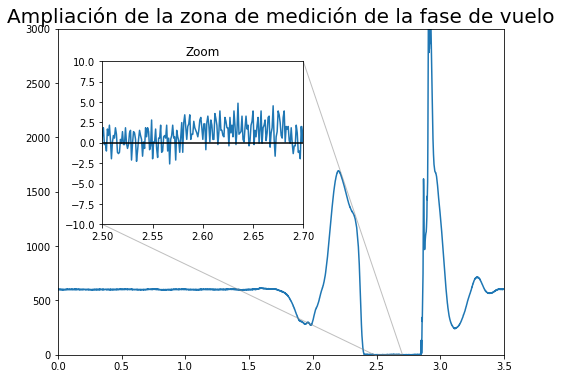

In [ ]:
#Figura ampliada de la fuerza vertical
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 3500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.1, 0.4, 0.45, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)

ax_zoom.axhline(0.0, color='k')

ax_zoom.set(title='Zoom', xlim=(2500/frec, 2700/frec), ylim=(-10, 10))# , xticks=[-1,0,1], yticks = [-0.01, 0, 0.01, 0.02])

ax.set_title('Ampliación de la zona de medición de la fase de vuelo', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

Es por esto por lo que para medir el peso no podemos tomarlo de un valor puntual, sino que debemos hacer un promedio de un tramo del salto en el que la fuerza vertical sea estable. Normalmente en los CMJ se hace en la parte inicial. Por eso, cuando se hace el registro es conveniente poner en marcha la plataforma unos 2 s antes de que se empiece a mover el saltador.

En este caso, realizaremos el promedio entre los datos 500 y 1000. Sabiendo que la plataforma estaba configurada para registrar con una frecuencia de 1000 Hz, quiere decir que estamos midiendo en una ventana de medio segundo.

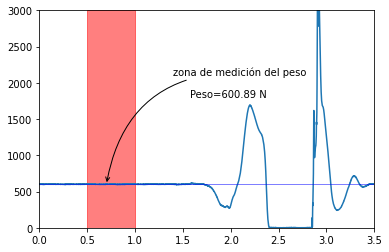

In [ ]:
iniPeso = 500
finPeso = iniPeso + 500
peso=Fz[iniPeso:finPeso].mean()

#Presenta los datos
fig, ax = plt.subplots()
plt.plot(t, Fz)
#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 3500/frec), ylim=(0, 3000))

ax.axhline(peso, color='b', lw=0.5)
ax.axvspan(iniPeso/frec, finPeso/frec, alpha=0.5, color='r')

ax.annotate('zona de medición del peso',
            xy=(700/frec, peso), xycoords='data',
            xytext=(0.4, 0.7), textcoords='axes fraction', #en este caso, las coordenadas del texto son relativas al tamaño del cuadro de los ejes (de 0 a 1)
            arrowprops=dict(arrowstyle='->', color='black', connectionstyle='angle3,angleA=0,angleB=80')) #con algle3 se puede especificar el ángulo de la flecha al inicio y al final

ax.text(0.45, 0.6, 'Peso={0:.2f} N'.format(peso), transform=ax.transAxes)

plt.show()

Es conveniente realizal la medición del peso en cada registro, aunque se trate de la misma persona realizando varios saltos. Esto es porque puede haber ligeras variaciones en cada medición por causas externas, y los cálculos que realizaremos a posteriori son muy sensibles al valor de peso utilizado.

# Búsqueda del inicio del salto

Una vez conocemos el peso de la persona que realizó el salto, tenemos que ser capaces de detectar automáticamente cuándo se produce el inicio del movimiento. Esto va a ser distinto dependiendo del tipo de salto de que se trate. En este ejemplo, se trata de un CMJ, por lo que el inicio del salto se produce cuando el valor de fuerza vertical desciende respecto al valor del peso. Sería fácil detectar cuándo se produce esto buscando en qué instante la variable Fz es menor que la variable peso, sin embargo, como hemos visto anteriormente, la medición de la fuerza incluye ruido inherente al aparato de medida, y por otra parte, la persona puede realizar ciertos movimientos inapreciables a simple vista pero que la plataforma es capaz de medir. Por eso, debemos utilizar un algoritmo más robusto y que sea aplicable a cualquier salto.

Se suelen aplicar dos aproximaciones:

1- Buscar cuándo Fz es menor que un porcentaje del peso, por ejemplo, el 90%.

2- Buscar cuándo Fz es menor que un umbral que tenga en cuenta el propio ruido de la señal, normalmente restando al peso un número de veces la desviación típica (SD) de la zona donde se midió el peso.

In [ ]:
#BUSCA EL INICIO DEL SALTO USANDO COMO UMBRAL 5 DESVIACIONES TÍPICAS DEL REGISTRO DE FUERZA EN LA ZONA ESTABLE DE MEDICIÓN DEL PESO
umbralIni=peso-5*Fz[iniPeso:finPeso].std()

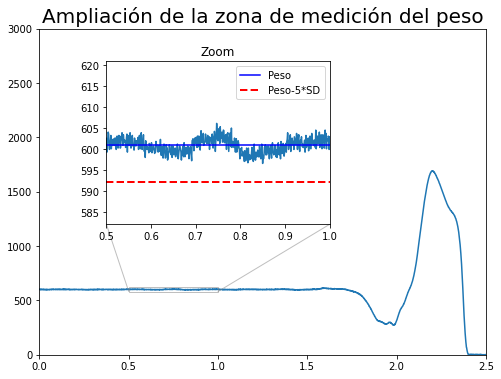

In [ ]:
#Figura ampliada del peso y el umbral
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 2500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.15, 0.4, 0.50, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)
ax_zoom.axhline(peso, color='b', label='Peso') #línea del peso
ax_zoom.axhline(umbralIni, color='r', linestyle='--', lw=2, label='Peso-5*SD') #umbral usado para determinar el inicio del movimiento 

ax_zoom.legend()
ax_zoom.set(title='Zoom', xlim=(iniPeso/frec, finPeso/frec), ylim=(umbralIni-10, peso+20))# , xticks=[-1,0,1], yticks = [-0.01, 0, 0.01, 0.02])

ax.set_title('Ampliación de la zona de medición del peso', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

Para detectar instantes automáticamente, se pueden utilizar distintas estrategias. Aquí vamos a usar una librería creada por Marcos Duarte llamada [*detecta*](https://pypi.org/project/detecta/). En primer lugar la instalamos en el sistema y luego la importamos.

In [ ]:
#Instala librería detecta (Marcos Duarte)
!pip install detecta

from detecta import detect_onset

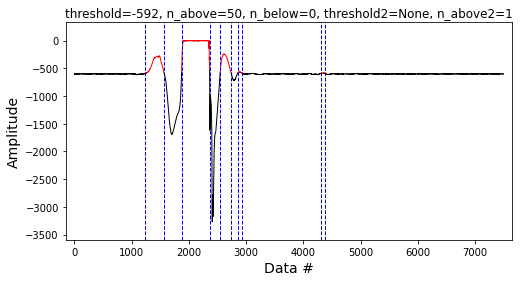

In [ ]:
indices=detect_onset(-Fz[iniPeso:], -umbralIni, n_above=50, n_below=0, show=True) #empieza a buscar desde que iniciamos la medida del peso
iniSalto=indices[0,0]+iniPeso #se suma iniPeso porque hemos empezado a buscar desde el inicio de la medida del peso


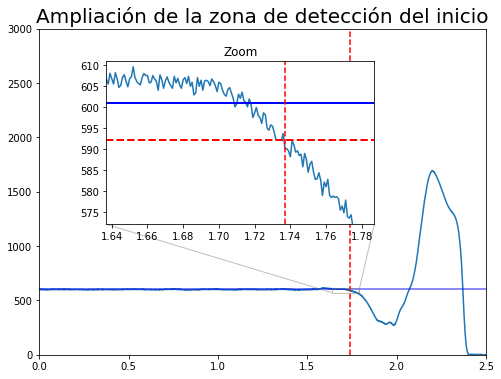

El inicio del salto se produce a los 1.737 s desde el inicio del registro.


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)
ax.axhline(peso, color='b', alpha=0.6)
ax.axvline(iniSalto/frec, c='r', ls='--')

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 2500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.15, 0.4, 0.60, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)
ax_zoom.axhline(umbralIni, color='r', linestyle='--', lw=2)
ax_zoom.axhline(peso, color='b', lw=2)
ax_zoom.axvline(iniSalto/frec, c='r', ls='--')

ax_zoom.set(title='Zoom', xlim=((iniSalto-100)/frec, (iniSalto+50)/frec), ylim=(umbralIni-20, peso+10))# , xticks=[-1,0,1], yticks = [-0.01, 0, 0.01, 0.02])

ax.set_title('Ampliación de la zona de detección del inicio', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

print('El inicio del salto se produce a los {:.3f} s desde el inicio del registro.'.format(iniSalto/frec))

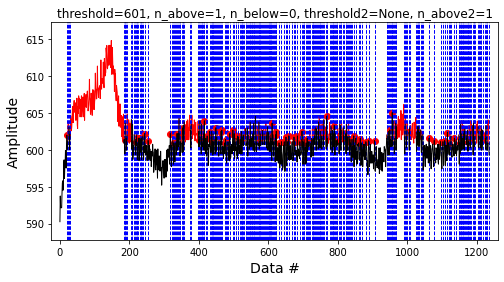

In [ ]:
#Para un ajuste más fino, ahora busca hacia atrás hasta el peso
indices=detect_onset(Fz[iniSalto:iniPeso:-1], peso, n_above=1, n_below=0, show=True)
iniSalto-=indices[0,0]-1

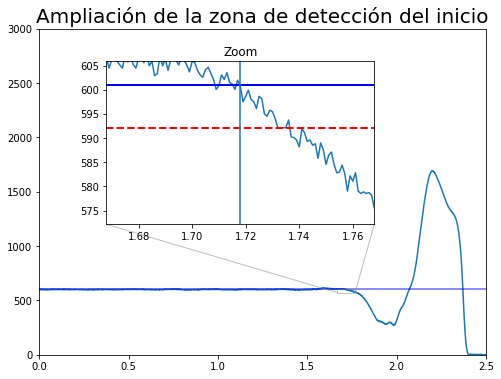

El inicio del salto se produce a los 1.718 s desde el inicio del registro.


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
# gráfica grande
ax.plot(t, Fz)
ax.axhline(peso, color='b', alpha=0.6)

#Ajusta límites de la gráfica grande
ax.set(xlim=(0.0, 2500/frec), ylim=(0, 3000))

#Ubica la gráfica ampliada dentro de la figura grande
ax_zoom = ax.inset_axes([0.15, 0.4, 0.60, 0.50]) #se pasa por orden la posición x, y, ancho y alto

#crea la gráfica pequeña
ax_zoom.plot(t, Fz)
ax_zoom.axhline(umbralIni, color='r', linestyle='--', lw=2)
ax_zoom.axhline(peso, color='b', lw=2)
ax_zoom.axvline(iniSalto/frec)

ax_zoom.set(title='Zoom', xlim=((iniSalto-50)/frec, (iniSalto+50)/frec), ylim=(umbralIni-20, peso+5))# , xticks=[-1,0,1], yticks = [-0.01, 0, 0.01, 0.02])

ax.set_title('Ampliación de la zona de detección del inicio', fontsize=20)

#Indica automáticamente la región ampliada encuadrándola y haciendo el efecto de zoom
ax.indicate_inset_zoom(ax_zoom)

plt.show()

print('El inicio del salto se produce a los {:.3f} s desde el inicio del registro.'.format(iniSalto/frec))

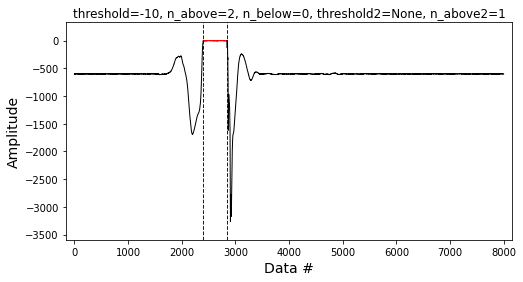

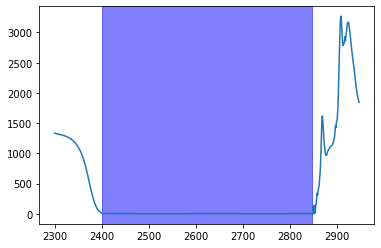

Altura del salto según el tv = 0.245 m


In [ ]:
#BUSCA EL TIEMPO DE VUELO
#con el tiempo de vuelo es más fácil porque podemos fijar unumbral más claro, por ejemplo cuando la fuerza es inferior a 10 N
umbralVuelo=10.0

indVuelo = detect_onset(-Fz, -umbralVuelo, n_above=2, n_below=0, show=True)
despegue = indVuelo[0,0]
aterrizaje = indVuelo[0,1]

#Presenta los datos
fig, ax = plt.subplots()
plt.plot(range(despegue-100, aterrizaje+100), Fz[despegue-100:aterrizaje+100])
ax.axvspan(despegue, aterrizaje, alpha=0.5, color='b')
plt.show()

#El tiempo de vuelo sería:
tv=(aterrizaje-despegue)/frec
#y la altura es:
h=9.8*tv**2/8
print('Altura del salto según el tv = {:.3f} m'.format(h))



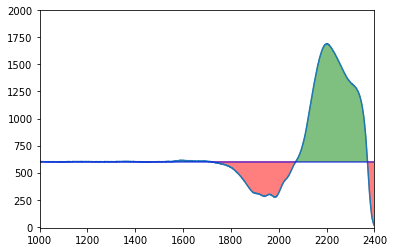

In [ ]:
fig, ax = plt.subplots()
plt.plot(Fz)
ax.axhline(peso, color='b', alpha=0.6)

ax.fill_between(range(0,8000), peso, Fz, where= Fz>peso, color='g', alpha=0.5) #rellena impulso positivo
ax.fill_between(range(0,8000), peso, Fz, where= Fz<peso, color='r', alpha=0.5) #rellena impulso negativo

#Ajusta límites del eje X
ax.set_xlim(1000, despegue)
ax.set_ylim(-10, 2000)
plt.show()


# Cálculo de variables relacionadas con el movimiento del centro de gravedad

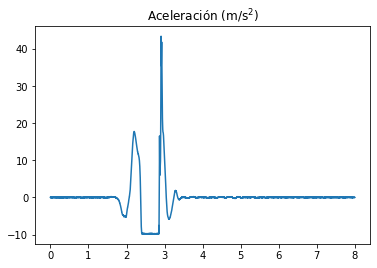

In [ ]:
aceleracion=(Fz-peso)/(peso/9.8)
plt.plot(t, aceleracion)
plt.title('Aceleración (m/s$^2$)')
plt.show()

La velocidad es la integral de la aceleración respecto al tiempo. Para calcularla se puede utilizar una función del módulo scipy. 

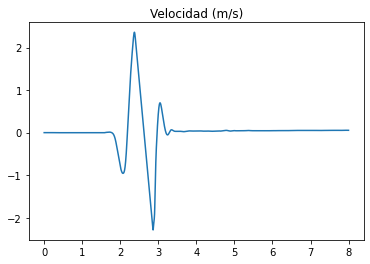

In [ ]:
import scipy.integrate as integrate

veloc= integrate.cumtrapz(aceleracion, dx=0.001, initial=0)
plt.plot(t, veloc)
plt.title('Velocidad (m/s)')
plt.show()

El cálculo de la velocidad es muy sensible a la dato de peso que se haya introducido, y en ocasiones sucede que la velocidad tiende a aumentar o a disminuir con el tiempo. En este caso se ve aceptable porque la velocidad se encuentra en torno a cero tanto al principio como al final del salto.

Y la posición es la integral de la velocidad respecto al tiempo. Utilizamos la misma estrategia que antes para calcular la velocidad a partir de la aceleración.

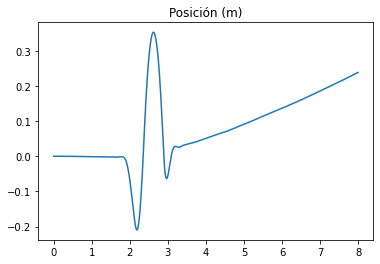

In [ ]:
posicion=integrate.cumtrapz(veloc, dx=0.001, initial=0)
plt.plot(t, posicion)
plt.title('Posición (m)')
plt.show()

En este caso, fíjate en ascenso brusco que sufre la posición después de la caída. Lo esperable sería qeu la posición empezara estable en cero y terminara también siendo estable en cero. Sin embargo, la posición se calcula integrando dos veces la aceleración, y como decía anteriormente el cálculo es muy sensible a qué valor de peso se utilice, y pequeños errores se van acumulando con el tiempo.
Suele ser frecuente que tras el impacto brusco con el suelo tras la fase de vuelo el cálculo de la posición se dispare.

# Cálculo de variables relacionadas con la fuerza

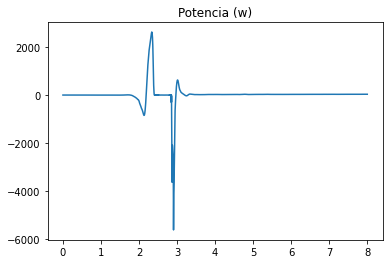

In [ ]:
potencia = Fz*veloc
plt.plot(t, potencia)
plt.title('Potencia (w)')
plt.show()

$RFD= \frac{F}{dt}$

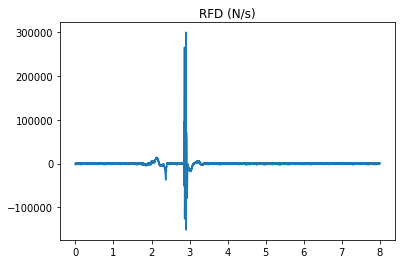

In [ ]:
#RFD, es la derivada de la fuerza respecto al tiempo
RFD = np.zeros(len(Fz),np.float)
RFD[1:-1] = (Fz[2:] - Fz[:-2]) / (t[2:] - t[:-2])
# Después calcula el primero y el último
RFD[0] = (Fz[1] - Fz[0]) / (t[1] - t[0])
RFD[-1] = (Fz[-1] - Fz[-2]) / (t[-1] - t[-2])

plt.plot(t, RFD)
plt.title('RFD (N/s)')
plt.show()

Para facilitar la representación gráfica, metemos todos los resultados en un mismo DataFrame.

In [ ]:
DatosJuntos = pd.DataFrame({'t':t, 'Fz':Fz, 'Aceleracion':aceleracion, 'Velocidad':veloc, 'Posicion':posicion, 'Potencia':potencia, 'RFD':RFD})
#quitamos la parte final en la que no hay información relevante
DatosJuntos = DatosJuntos[:4000]
DatosJuntos

,t,Fz,Aceleracion,Velocidad,Posicion,Potencia,RFD
0,0.000,602.418762,0.024927,0.000000,0.000000e+00,0.000000,-1742.4920
1,0.001,600.676270,-0.003492,0.000011,5.358657e-09,0.006438,-1585.0295
2,0.002,599.248703,-0.026774,-0.000004,8.509403e-09,-0.002646,158.3630
3,0.003,600.992996,0.001674,-0.000017,-2.181609e-09,-0.010197,1665.0810
4,0.004,602.578865,0.027538,-0.000002,-1.184499e-08,-0.001422,554.3860
...,...,...,...,...,...,...,...
3995,3.995,602.229713,0.021843,0.039713,5.062561e-02,23.916187,-633.6860
3996,3.996,601.755257,0.014105,0.039731,5.066534e-02,23.908161,0.5725
3997,3.997,602.230858,0.021862,0.039749,5.070507e-02,23.937888,950.2255
3998,3.998,603.655708,0.045100,0.039782,5.074484e-02,24.014735,-554.1690


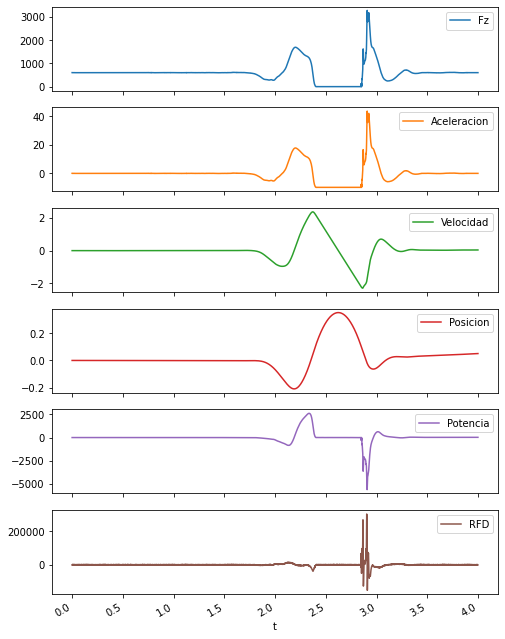

In [ ]:
DatosJuntos.plot(x='t', subplots=True, figsize=(8,12))
plt.show()

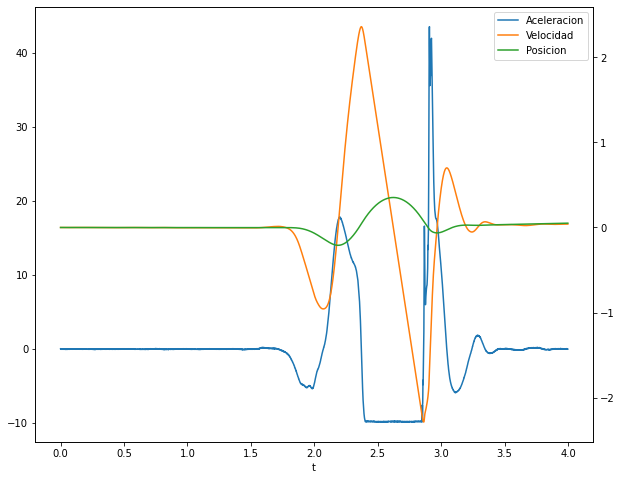

In [ ]:
DatosJuntos.plot(x='t', y=['Aceleracion', 'Velocidad', 'Posicion'], figsize=(10,8), secondary_y=['Velocidad', 'Posicion'], mark_right=False)
#ax.right_ax.set_ylabel('Velocidad (m/s), Posición (m)')

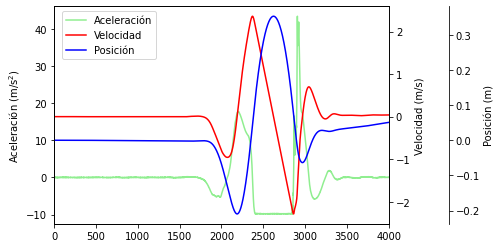

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx() #crea el segundo eje
ax3 = ax.twinx() #crea el segundo eje

ax.plot(aceleracion, 'lightgreen', label='Aceleración')
ax2.plot(veloc, 'r', label='Velocidad')
ax3.plot(posicion,'b', label='Posición')

ax.set_ylabel('Aceleración (m/s$^2$)')
ax2.set_ylabel('Velocidad (m/s)')
ax3.set_ylabel('Posición (m)')

#Ajusta límites del eje X
ax.set_xlim(0.0, 4000)

ax3.spines['right'].set_position(('outward', 60)) #aleja hacia la derecha el eje 3

fig.legend(bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes) #en este caso la leyenda hay que ponerla así para que incluya los dos ejes

plt.show()

## Otros gráficos de relación de variables

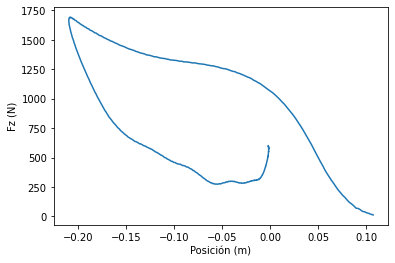

In [ ]:
fig, ax = plt.subplots()
ax.plot(posicion[iniSalto:despegue], Fz[iniSalto:despegue])
ax.set_xlabel('Posición (m)')
ax.set_ylabel('Fz (N)')
plt.show()

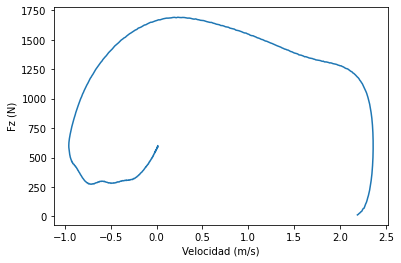

In [ ]:
fig, ax = plt.subplots()
ax.plot(veloc[iniSalto:despegue], Fz[iniSalto:despegue])
ax.set_xlabel('Velocidad (m/s)')
ax.set_ylabel('Fz (N)')
plt.show()

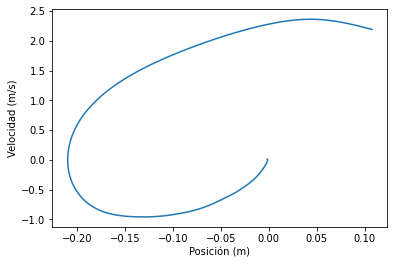

In [ ]:
fig, ax = plt.subplots()
ax.plot(posicion[iniSalto:despegue], veloc[iniSalto:despegue])
ax.set_xlabel('Posición (m)')
ax.set_ylabel('Velocidad (m/s)')
plt.show()

Modelado de la curva Fuerza/Posición (Linthorne, 2020) A sharper decrease in ground reaction force toward the end of the upward propulsion phase could arise from a more optimal timing of the proximal-distal extension of the hip, knee, and ankle joints. In the simple countermovement jump model used in the present study (Figure 3; Equation (2)), a sharper decrease in ground reaction force is equivalent to a greater power exponent, A. A greater A results in a greater peak power and a higher position of the jumper’s centre of mass at peak power. Therefore, a higher position at peak power might be an indicator of a superior jumping technique where the athlete has greater ability to produce force toward the end of the take-off.



#Bibliografía

Linthorne, N. P. (2020). The correlation between jump height and mechanical power in a countermovement jump is artificially inflated. *Sports Biomechanics*, 00(00), 1–19. https://doi.org/10.1080/14763141.2020.1721737